In [1]:
!pip -q install -U transformers datasets evaluate scikit-learn accelerate --progress-bar off
!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [2]:
import urllib.request
import os, zipfile, glob, pandas as pd

url = 'https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%206/W6D1%20GenAi%20France/Basics%20of%20BERT%20and%20XLM-RoBERTa%20-%20PyTorch%20-%202.zip'
output_zip = 'monfichier.zip'

urllib.request.urlretrieve(url, output_zip)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall('data')


In [3]:
root = glob.glob("data/*BERT*XLM*")[0]          # 'data/Basics of BERT and XLM-RoBERTa - PyTorch - 2'
print("root dir →", root, os.listdir(root))

root dir → data/Basics of BERT and XLM-RoBERTa - PyTorch ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv']


In [4]:
for inner_zip in glob.glob(f"{root}/*.zip"):
    with zipfile.ZipFile(inner_zip) as z:
        z.extractall(root)                      # drops train.csv / test.csv next to the zips
    print("unzipped:", inner_zip)

unzipped: data/Basics of BERT and XLM-RoBERTa - PyTorch/train.csv.zip
unzipped: data/Basics of BERT and XLM-RoBERTa - PyTorch/test.csv.zip


In [5]:
TRAIN_CSV = f"{root}/train.csv"
TEST_CSV  = f"{root}/test.csv"      # will exist if the dataset shipped one
train_df = pd.read_csv(TRAIN_CSV)
print("\nTrain preview:\n", train_df.head())
print("\nLabel distribution:\n", train_df['label'].value_counts())
test_df = pd.read_csv(TEST_CSV) if os.path.exists(TEST_CSV) else None


Train preview:
            id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  

Label distribution:
 label
0    4176
2    4064
1    3880
Name: count, dtype: int64


OK  label 0 : 	Entailment (implication)
    label 1 :   Neutral
    label 2 :   Contradiction

In [6]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Entailment (0): 4176 exemples
Neutral (1): 3880 exemples
Contradiction (2): 4064 exemples


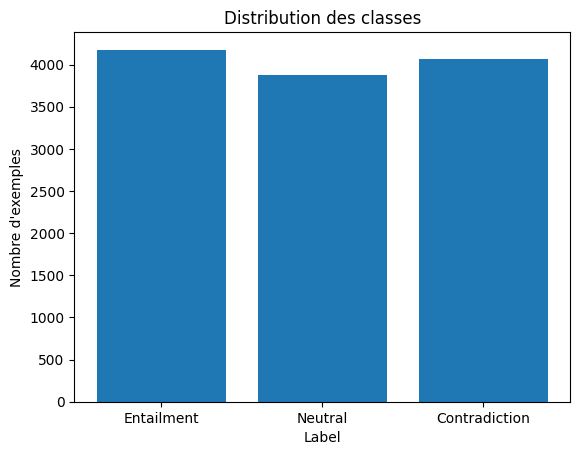

In [7]:
import matplotlib.pyplot as plt

label_counts = train_df['label'].value_counts().sort_index()
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}

for label, count in label_counts.items():
    print(f"{label_names[label]} ({label}): {count} exemples")

plt.bar(label_names.values(), label_counts.values)
plt.title("Distribution des classes")
plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch

# === Config ===
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = 3
n_splits = 5

# === Fonction de prétraitement ===
def preprocess_function(examples):
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# === Fonction de métriques ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
# === K-Fold ===
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["label"])):
    print(f"\n🚀 Fold {fold + 1}/{n_splits}")

    train_df_fold = train_df.iloc[train_idx].reset_index(drop=True)
    val_df_fold = train_df.iloc[val_idx].reset_index(drop=True)

    # Convertir en datasets Hugging Face
    train_dataset = Dataset.from_pandas(train_df_fold)
    val_dataset = Dataset.from_pandas(val_df_fold)

    # Tokenization
    train_dataset = train_dataset.map(preprocess_function, batched=True)
    val_dataset = val_dataset.map(preprocess_function, batched=True)

    # Supprimer les colonnes inutiles
    to_remove = ["id", "premise", "hypothesis", "lang_abv", "language", "__index_level_0__"]
    train_dataset = train_dataset.remove_columns([col for col in to_remove if col in train_dataset.column_names])
    val_dataset = val_dataset.remove_columns([col for col in to_remove if col in val_dataset.column_names])


    # Set format for PyTorch
    train_dataset.set_format("torch")
    val_dataset.set_format("torch")

    # Charger un nouveau modèle BERT à chaque fold
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_dir=f"./logs_fold_{fold}",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer, # Keep tokenizer for now as processing_class needs further setup
        compute_metrics=compute_metrics
    )

    # Entraîner
    trainer.train()

    # Évaluer
    eval_result = trainer.evaluate()
    fold_results.append(eval_result)

# === Résumé des résultats ===
print("\n📊 Résultats par fold :")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1}: Accuracy = {result['eval_accuracy']:.4f}, F1 = {result['eval_f1']:.4f}")

accs = [r["eval_accuracy"] for r in fold_results]
f1s = [r["eval_f1"] for r in fold_results]

print(f"\n✅ Moyenne accuracy: {np.mean(accs):.4f}")
print(f"✅ Moyenne F1      : {np.mean(f1s):.4f}")


🚀 Fold 1/5


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.946300,0.836106,0.630776,0.630915
2,0.698400,0.821766,0.648927,0.650431
3,0.546400,0.907509,0.648515,0.648697



🚀 Fold 2/5


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.949900,0.824939,0.633251,0.630859
2,0.728900,0.806603,0.650578,0.649840
3,0.544400,0.900194,0.650990,0.651214



🚀 Fold 3/5


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.935700,0.827992,0.635314,0.631188
2,0.702400,0.799806,0.657591,0.658071
3,0.536100,0.894766,0.669554,0.669869



🚀 Fold 4/5


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.932800,0.841022,0.620462,0.619789
2,0.695000,0.836057,0.643564,0.644416
3,0.545500,0.928385,0.649340,0.649710



🚀 Fold 5/5


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.937300,0.794016,0.658416,0.655538
2,0.712100,0.798903,0.676980,0.673959
3,0.541800,0.875883,0.675330,0.675812



📊 Résultats par fold :
Fold 1: Accuracy = 0.6489, F1 = 0.6504
Fold 2: Accuracy = 0.6506, F1 = 0.6498
Fold 3: Accuracy = 0.6576, F1 = 0.6581
Fold 4: Accuracy = 0.6436, F1 = 0.6444
Fold 5: Accuracy = 0.6584, F1 = 0.6555

✅ Moyenne accuracy: 0.6518
✅ Moyenne F1      : 0.6517
